# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [16]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels as sm
from statsmodels.stats.weightstats import DescrStatsW
import scipy.stats as stats
import math

In [3]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('/users/youcefdjeddar/downloads/hospital_readmit/data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [4]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/Users/youcefdjeddar/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


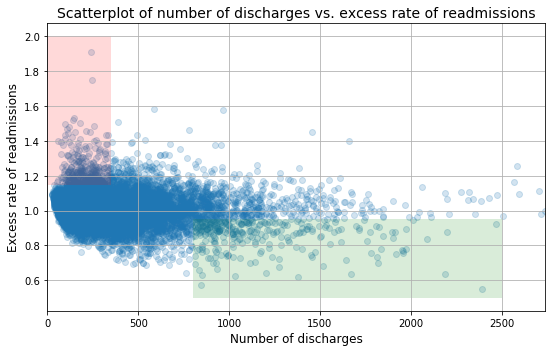

In [5]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [9]:
# Let's first separate the data into two segments: less than 100 Number of Discharges and more than 1000 Number of Discharges
small = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] < 100]
large = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] > 1000]
print("<100 discharge hosptials:",len(small),"\n>100 discharge hospitals:",len(large),"\nother hospitals:",
      len(clean_hospital_read_df)-len(small)-len(large))

print("Total Number of hospitals in the data:",len(clean_hospital_read_df))

<100 discharge hosptials: 1269 
>100 discharge hospitals: 463 
other hospitals: 9846
Total Number of hospitals in the data: 11578


I will now get rid of the missing values to have more accuracy while calculating the mean

In [12]:
#Update the small group to include only the Excess Readmission Ratio
small_excess = small['Excess Readmission Ratio']

#Drop all samples with 0 readmissions or in other words NaN data value for excess Ratio.
small_excess_clean = small_excess.dropna()

#Rename the column to Err that includes the hospital's excess ratio.
df_small = small_excess_clean.to_frame(name='Err')


# Repeat the process for the large hospital
large_excess = large['Excess Readmission Ratio']
large_excess_clean = large_excess.dropna()
df_large = large_excess_clean.to_frame(name='Err')

#Now we print the means and total number of samples of each group
print("Mean <100:",df_small['Err'].mean(),"\nNumber of <100 Hospitals:",len(df_small))
print("\nMean >100:",df_large['Err'].mean(),"\nNumber of >100 Hospitals:",len(df_large))

Mean <100: 1.0226183501683501 
Number of <100 Hospitals: 1188

Mean >100: 0.9783354211663067 
Number of >100 Hospitals: 463


I will now perform a t-test of difference (since I have the two means)

Ho: there's no difference between the two means of the two samples

H1: there's a difference between the two means of the two samples

In [15]:
t_stat, p_value = stats.ttest_ind(df_small['Err'], df_large['Err'], equal_var = False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 7.601742418500486
p-value: 1.2752435451140344e-13


The p-value being extremly small (smaller than 0.01) the null hypothesis can be rejected unequivocally. Therefore, there is a significant difference between the two means.

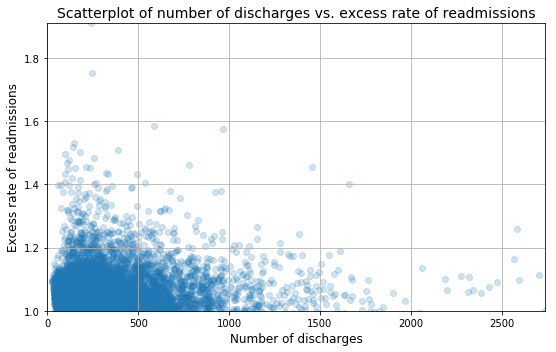

In [11]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.set_xlim([0, max(x)])
ax.set_ylim([1, max(y)])

ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

Scatter plots generally can help determine how the date behaves. The above plot focuses directly on the problem we are trying to solve. We can visualize the number of hospitals exceeding the readmission rate (>1.0). In addition, we can identify that the number of hospitals exceeding the 1.0 ratio decreases significantly as th discharges increase. 
